In [2]:
# -*- coding: utf-8 -*-
import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image
from skimage import io as skio


# POUR LA MORPHO
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

import IPython


In [3]:
#%%
# VOUS DEVEZ FIXER LES DEUX VARIABLES SUIVANTES:
colaboratory=True #mettre True si vous utilisez google colab
notebook=False   # mettre True si vous utilisez un notebook local
# les seuls couples possibles sont (False,False)= travailler localement sans notebook
# (False,True): jupyternotebook local
# (True, False): google colab


assert (not (colaboratory and notebook)), "Erreur, choisissez google colab ou notebook local mais pas les deux en meme temps"

if colaboratory: #Si google colab on installe certaines librairies
    !pip install soundfile
    from IPython.display import Audio
    !pip install bokeh
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()
    !wget https://perso.telecom-paristech.fr/ladjal/donnees_IMA203.tgz
    !tar xvzf donnees_IMA203.tgz
    os.chdir('donnees_IMA203')

if notebook: # si notebook normal dans une machine locale vous devez installer bokeh vous-meme
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()


--2024-01-19 13:34:43--  https://perso.telecom-paristech.fr/ladjal/donnees_IMA203.tgz
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 290918 (284K) [application/x-gzip]
Saving to: ‘donnees_IMA203.tgz’

donnees_IMA203.tgz  100%[===================>] 284.10K  1.02MB/s    in 0.3s    

2024-01-19 13:34:44 (1.02 MB/s) - ‘donnees_IMA203.tgz’ saved [290918/290918]

donnees_IMA203/
donnees_IMA203/lacornou.tif
donnees_IMA203/lena.tif


In [4]:
def viewimage(im, normalize=True,titre='',displayfilename=False):
  imin=im.copy().astype(np.float32)
  if normalize:
    imin-=imin.min()
  if imin.max()>0:
    imin/=imin.max()
  else:
    imin=imin.clip(0,255)/255

  imin=(imin*255).astype(np.uint8)
  filename=tempfile.mktemp(titre+'.png')
  if displayfilename:
    print(filename)
  plt.imsave(filename, imin, cmap='gray')
  IPython.display.display(IPython.display.Image(filename))

In [5]:
#%% fonctions utiles au TP

def appfiltre(u,K):
    """ applique un filtre lineaire (en utilisant une multiplication en Fourier) """

    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    out=np.real(ifft2(fft2(u)*fft2(K)))
    return out

def degrade_image(im,br):
    """degrade une image en lui ajoutant du bruit"""
    out=im+br*np.random.randn(*im.shape)
    return out

def  grady(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient en bas est nul"""

    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:-1,:]=-I[:-1,:]+I[1:,:]
    M[-1,:]=np.zeros((n,))
    return M

def  gradx(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient a droite est nul"""

    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:,:-1]=-I[:,:-1]+I[:,1:]
    M[:,-1]=np.zeros((m,))
    return M

def div(px,py):
    """calcule la divergence d'un champ de gradient"""
    """ div= - (grad)^*, i.e. div est la transposee de l'operateur gradient"""
    (m,n)=px.shape
    assert px.shape==py.shape , " px et py n'ont pas la meme taille dans div"
    Mx=np.zeros((m,n))
    My=np.zeros((m,n))

    My[1:-1,:]=py[1:-1,:]-py[:-2,:]
    My[0,:]=py[0,:]
    My[-1,:]=-py[-2,:]

    Mx[:,1:-1]=px[:,1:-1]-px[:,:-2]
    Mx[:,0]=px[:,0]
    Mx[:,-1]=-px[:,-2]
    return Mx+My

def gradient_TV(v,u,lamb):
    """ calcule le gradient de la fonctionnelle E2 du TP"""
# on n'utilise pas gradx et grady car pour minimiser
# la fonctionnelle E2 par descente de gradient nous avons choisi
# de prendre les memes conditions au bords que pour la resolution quadratique
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Kxback=np.zeros((sy,sx))
    Kyback=np.zeros((sy,sx))
    Kxback[0,0]=-1
    Kxback[0,-1]=1
    Kyback[0,0]=-1
    Kyback[-1,0]=1

    Dx=appfiltre(u,Kx)
    Dy=appfiltre(u,Ky)
    ng=(Dx**2+Dy**2)**0.5+1e-5
    div=appfiltre(Dx/ng,Kxback)+appfiltre(Dy/ng,Kyback)
    return 2*(u-v)-lamb*div

def gradient_TV_nonperiodique(v,u,lamb):
     """ calcule le gradient de la fonctionnelle E2 du TP"""
     gx=gradx(u)
     gy=grady(u)
     ng=((gx**2)+(gy**2))**0.5+1e-5
     dive=div(gx/ng,gy/ng)
     return 2*(u-v)-lamb*dive


def resoud_quad_fourier(K,V):
    """trouve une image im qui minimise sum_i || K_i conv im - V_i||^2
     ou les K_i et les Vi sont des filtres et des images respectivement """

    n=len(K)
    assert len(K) == len(V) , "probleme de nombre de composantes dans resoud_quad"
    (sy,sx)=K[0].shape
    numer=np.vectorize(complex)(np.zeros((sy,sx)))
    denom=np.vectorize(complex)(np.zeros((sy,sx)))
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    for k in range(n):
        fV=fft2(V[k])
        fK=fft2(K[k])
        #print('type de fV',fV.dtype,' type de fK',fK.dtype)
        numer+=np.conj(fK)*fV
        denom+=abs(fK)**2
    return np.real(ifft2(numer/denom))

def minimisation_quadratique(v,lamb):
    """ minimise la fonctionnelle E1 du TP"""
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    delta=np.zeros((sy,sx))
    delta[0,0]=1.0
    s=lamb**0.5
    K=(s*Kx,s*Ky,delta)
    V=(np.zeros((sy,sx)),np.zeros((sy,sx)),v)
    return resoud_quad_fourier(K,V)

def norme_VT(I):
    """ renvoie la norme de variation totale de I"""
    (sy,sx)=I.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Dx=appfiltre(I,Kx)
    Dy=appfiltre(I,Ky)
    ng=(Dx**2+Dy**2)**0.5
    return ng.sum()

def norme_VT_nonperiodique(u):
    gx=gradx(u)
    gy=grady(u)
    ng=((gx**2)+(gy**2))**0.5
    return ng.sum()

def norm2(x):
    return ((x**2).sum())**0.5

def E2_nonperiodique(u,v,lamb): # renvoie l'énergie E2
    return lamb*norme_VT_nonperiodique(u)+norm2(u-v)**2


def minimise_TV_gradient(v,lamb,pas,nbpas):
    """ minimise E2 par descente de gradient a pas constant """
    u=np.zeros(v.shape)
    Energ=np.zeros(nbpas)
    for k in range(nbpas):
        # print(k)
        Energ[k]=E2_nonperiodique(u,v,lamb)
        u=u-pas*gradient_TV_nonperiodique(v,u,lamb)
    return (u,Energ)


def projection(I,a,itmax):
    """ calcule la projection de I sur G_a
        G_a est le sous-gradient de TV en zero
        Comme vu dans le poly cette projection permet de resoudre le probleme
        de debruitage TV (E2)"""
    # ici on utilise les conditions au bord de von neuman
    # i.e. on utilise gradx et grady definis plus haut et non pas une convolution circulaire
    (m,n)=I.shape
    t=0.1249
    px=np.zeros((m,n))
    py=np.zeros((m,n))
    un=np.ones((m,n))

    for it in range(itmax):
        N=div(px,py)-I/a
        Gx=gradx(N)
        Gy=grady(N)
        G=(Gx**2+Gy**2)**0.5
        pxnew=(px+t*Gx)/(un+t*G)
        pynew=(py+t*Gy)/(un+t*G)
        px=pxnew
        py=pynew
    # la projection est la divergence du champ px,py
    P=a*div(px,py)
    return P

def vartotale_Chambolle(v,lamb,itmax=100):
    """ Trouve une image qui minimise lamb*TV(I)+||I-v||^2
    en utilisant la projection dur G_a"""
    (m,n)=v.shape
    P=projection(v,lamb/2,itmax)
    return v-P


def imread(fichier):
    return np.float32(skio.imread(fichier))


In [7]:
#%% lire une image
im=imread('lena.tif') #ATTENTION IL FAUT ETRE DANS LE BON REPERTOIRE (utiliser os.chdir())

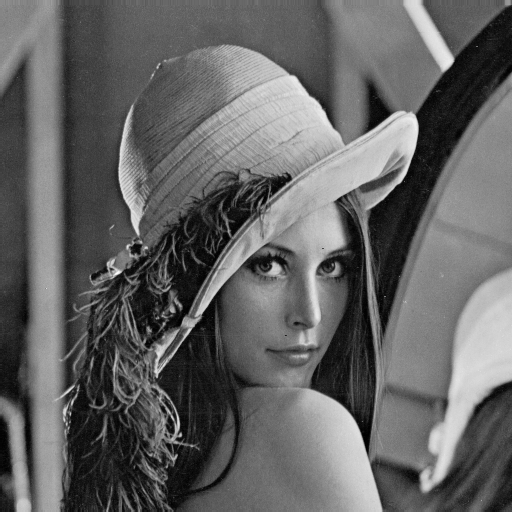

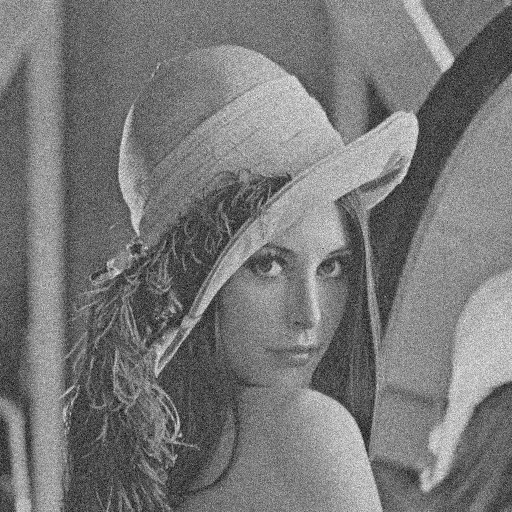

In [8]:
# voir l'image
viewimage(im,titre='ORIGINALE')
#degrader une image

imb=degrade_image(im,25)

# voir l'image bruitée
viewimage(imb,titre='BRUITEE')

# 1.1

L'outil resoud_quad_fourier trouve une image im qui minimise $\sum_i \| K_i \ast \text{im} - V_i \|^2$ ou les $K_i$ et les $V_i$ sont des filtres et des images respectivement.
Or on peut réecrire $$\| u - v \|^2 + \int\int \| \nabla u(x, y) \|^2 \,dx \,dy = \|\delta * u -v\|^2 + \|K_1*f-0\|^2 + \|K_2*f-0\|^2$$
Perceval --> $$=\sum_i^N \sum_{\omega}|\hat{K_i}(\omega)\hat{f}(\omega)-\hat{v_i}(\omega)|^2 $$
$$
=\sum_{\omega}\sum_i|K_i(\omega)\hat{f}(\omega)-\hat{v_i}(\omega)|
$$
$$
=\sum_i^N|\alpha_it^2-\beta_i|^2 = |\alpha_i|^2|t|^2 - 2Re(\beta_i \bar{\alpha_i}\bar{t})
$$
$$
=A|t|^2 - Re(\beta \bar{t}) = A(|t|^2-2Re(\beta\bar{t}))
$$
$$
|t-\gamma|^2 = |t|^2 - 2Re(\bar{\gamma}\bar{t})
$$
$$
\hat{f}(\omega) = \frac {\sum \bar{\hat{K_i}(\omega)}-\hat{v_i}(\omega)} {\sum|K_i(\omega)|^2}
$$

# 1.2

Lorsque $ \lambda $ est petit, le débruitage est faiblement perciptible, lorsque $\lambda$ est très grand, on observe un bon débruitage, cependant il y a un flou important sur l'image.

# 1.3

In [11]:
# Dichotomie par rapport à lambda
im_b = degrade_image(im,25)
lambda_left = 0
lambda_right = 100
threshold = 0.1
diff = diff = norm2(minimisation_quadratique(im_b,100)-im_b)**2-norm2(im-im_b)**2
iter = 0
while abs(diff) > threshold:
    iter += 1
    lamb = (lambda_left + lambda_right)/2
    restau=minimisation_quadratique(im_b,lamb)
    diff = norm2(restau-im_b)**2-norm2(im-im_b)**2
    if diff < 0:
        lambda_left = lamb
    else :
        lambda_right = lamb

print("La différence est plus petite que",threshold,"pour lambda =",round(lamb,4),"et la différence est de",round(diff,4))
print(iter,"itérations requises")

La différence est plus petite que 0.1 pour lambda = 3.1894 et la différence est de 0.0186
31 itérations requises


# 1.4

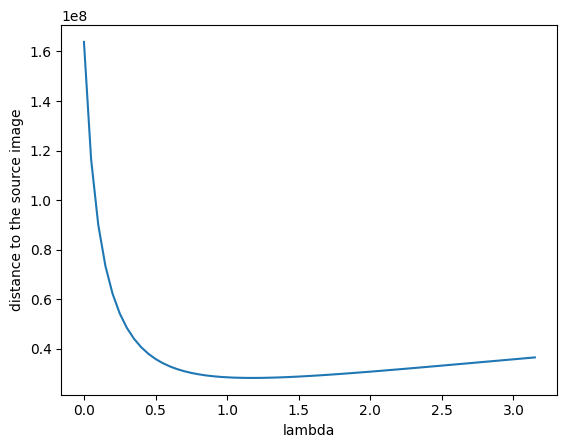

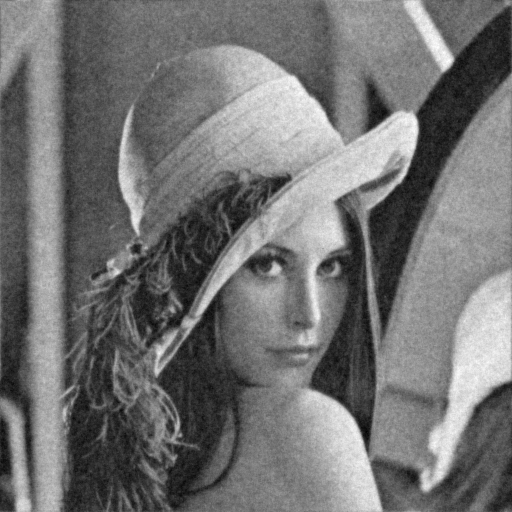

Meilleur lambda pour restauration quadratique : 1.15


In [15]:
lambdas = np.arange(0,3.2,0.05)
norms = []
for lamb in lambdas:
    restau = minimisation_quadratique(im_b,lamb)
    diff = norm2(im-restau)**2
    norms.append(diff)

plt.plot(lambdas,norms)
plt.xlabel('lambda')
plt.ylabel('distance to the source image')
plt.show()

min_index = norms.index(min(norms))
lambda_min = lambdas[min_index]
best_lambda_im = minimisation_quadratique(imb,lambda_min)
viewimage(best_lambda_im,titre='Meilleur lambda restauration quadratique')
print("Meilleur lambda pour restauration quadratique :",round(lambda_min,2))

Le meilleur $\lambda$ (1.15) est plus faible que celui trouvé précedemment. Cela s'explique par le fait que précedemment nous étions toujours à une certaine distance $\sigma$ de l'image d'origine, à la même distance que l'image bruité.

# 2.1

In [69]:
#%%
u1,en1=minimise_TV_gradient(imb, 40, 1, 20)
u05,en05=minimise_TV_gradient(imb, 40, 0.5, 20)
u01,en01=minimise_TV_gradient(imb, 40, 0.1, 20)
u01,en001=minimise_TV_gradient(imb, 40, 0.01, 20)

#u05inf,en05inf=minimise_TV_gradient(imb, 10, 0.5, 200)

print(en1[-1],en05[-1],en01[-1],en001[0])
viewimage

786690369677.199 2249436450.8105345 281047515.06994486 3472407032.3503613


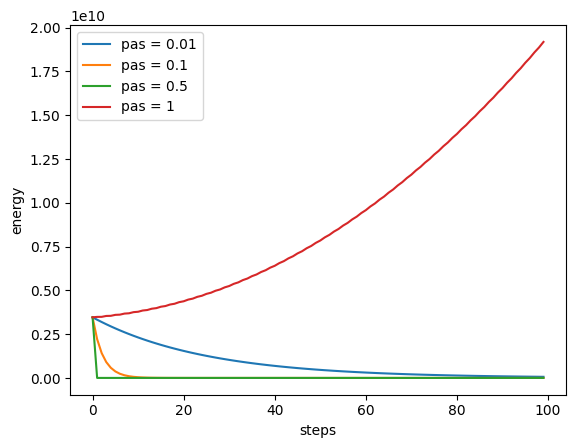

In [18]:
#%%
myim=imread('lena.tif')
imb=degrade_image(myim,25)
(u,energ)=minimise_TV_gradient(imb,1,0.1,100)   # pas = 0.1
(u,energ2)=minimise_TV_gradient(imb,1,1,100)       # pas = 1
(u,energ3)=minimise_TV_gradient(imb,1,0.01,100)   # pas = 0.01
(u,energ4)=minimise_TV_gradient(imb,1,0.5,100)   # pas = 0.5
plt.plot(energ3,label="pas = 0.01")
plt.plot(energ,label="pas = 0.1")
plt.plot(energ4,label="pas = 0.5")
plt.plot(energ2,label="pas = 1")
plt.xlabel('steps')
plt.ylabel('energy')
plt.legend()

Il semblerait qu'il y ait un seuil pour le pas à partir duquel la descente de gradient converge (lien avec la valeur Lipschitzienne de notre fonction). Il y a aussi un pas optimal qui permet la convergence la plus rapide (la valeur Lipschitzienne).

# 2.2

In [27]:
import time
startq = time.time()
minimisation_quadratique(imb,10)
timeq = time.time() - startq
startvt = time.time()
vartotale_Chambolle(imb,10)
timevt = time.time() - startvt
startgd = time.time()
minimise_TV_gradient(imb,1,0.1,100)
timegd = time.time() - startgd

print("Temps pour la minimisation quadratique :",round(timeq,2))
print("Temps pour la variation totale :",round(timevt,2))
print("Temps pour la descente de gradient :",round(timegd,2))


Temps pour la minimisation quadratique : 0.19
Temps pour la variation totale : 1.08
Temps pour la descente de gradient : 1.28


La méthode de Chambolle est beaucoup plus lente que la minimisation quadratique (\~0.9s et dépend de lambda) mais est un peu plus rapide que la descente de gradient (\~0.2s plus rapide et cela dépend du lambda et du pas).

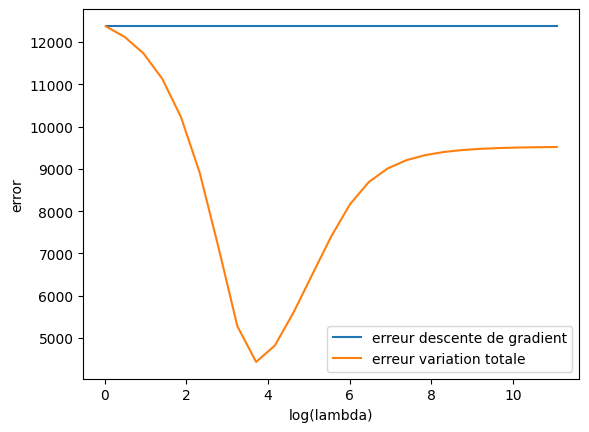

In [31]:
lambdas = np.arange(0.01,5,0.2)
lambdas = 10**lambdas
errvt = []
for lamb in lambdas:
    restva=vartotale_Chambolle(imb,round(lamb,3));
    errvt.append(norm2(restva-im))

restgd = minimise_TV_gradient(imb,1,0.5,100)[0]
err = norm2(restgd-im)
errgd = [err for i in range(len(lambdas))]

plt.plot(np.log(lambdas),errgd,label="erreur descente de gradient")
plt.plot(np.log(lambdas),errvt,label="erreur variation totale")
plt.xlabel('log(lambda)')
plt.ylabel('error')
plt.legend()

On a donc une méthode plus rapide et plus précise (quelle que soit la valeur de lambda) que la descente de gradient.

# 3

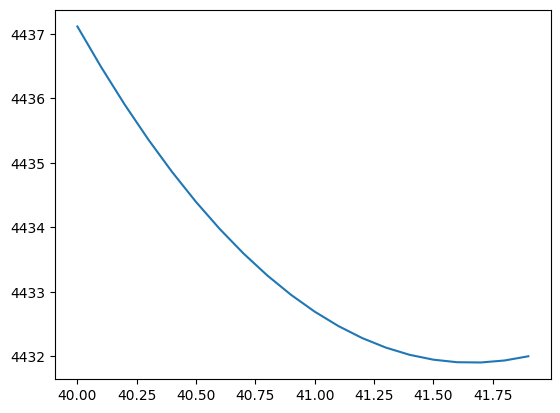

Meilleur lambda pour TV : 41.7


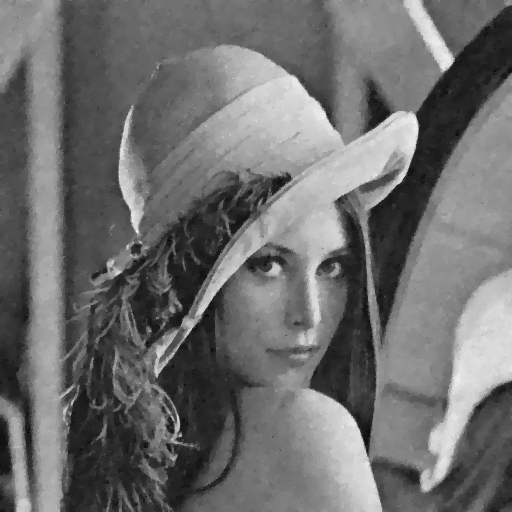

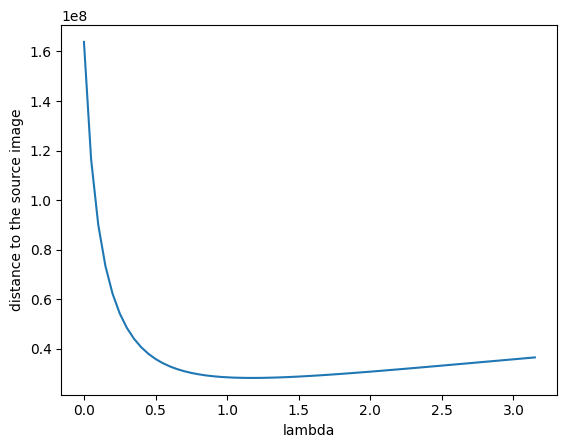

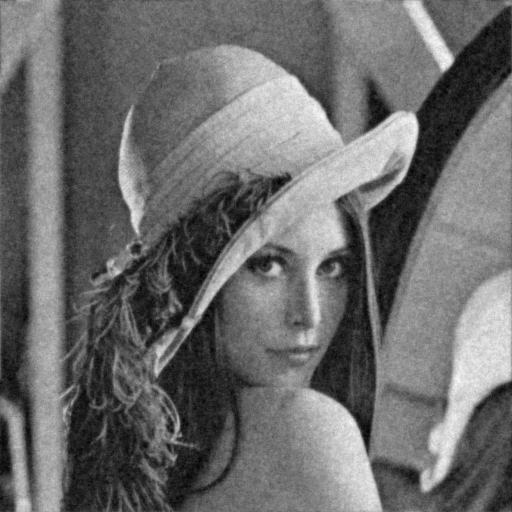

Meilleur lambda pour restauration quadratique : 1.15


In [30]:
myim=imread('lena.tif')
imb=degrade_image(myim,25)
errvt = []
lambdas = np.arange(40,42,0.1)
for lamb in lambdas:
    restva=vartotale_Chambolle(imb,round(lamb,3));
    errvt.append(norm2(restva-myim))

plt.plot(lambdas,errvt,label="erreur variation totale")
plt.show()

min_index_vt = errvt.index(min(errvt))
lambda_min_vt = lambdas[min_index_vt]
vt_im = vartotale_Chambolle(imb,lambda_min_vt)
print("Meilleur lambda pour TV :",round(lambda_min_vt,2))
viewimage(vt_im,titre='Meilleur lambda TV')

lambdas = np.arange(0,3.2,0.05)
norms = []
for lamb in lambdas:
    restau = minimisation_quadratique(im_b,lamb)
    diff = norm2(im-restau)**2
    norms.append(diff)

plt.plot(lambdas,norms)
plt.xlabel('lambda')
plt.ylabel('distance to the source image')
plt.show()

min_index = norms.index(min(norms))
lambda_min = lambdas[min_index]
best_lambda_im = minimisation_quadratique(imb,lambda_min)
viewimage(best_lambda_im,titre='Meilleur lambda restauration quadratique')
print("Meilleur lambda pour restauration quadratique :",round(lambda_min,2))

Qualitativement, la minimisation quadratique permet de garder plus de détails relatifs à l'image (cheveux fins et continus, ligne sur le chapeau) mais est plus bruitée. L'image avec la méthode TV est plus nette dans le sens où il n'y a plus de bruits mais elle est cependant assez floue avec une perte d'informations (cheveux, chapeau).